<a href="https://colab.research.google.com/github/MykhailoFokin/segmentation/blob/master/Segmentation_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MykhailoFokin/segmentation

Cloning into 'segmentation'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 99 (delta 0), reused 0 (delta 0), pack-reused 96
Unpacking objects: 100% (99/99), done.


In [2]:
%tensorflow_version 1.x
%matplotlib inline

import json
import numpy as np
import os
from pycocotools.coco import COCO
from tqdm import tqdm
from PIL import Image
import cv2
import keras
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


Using TensorFlow backend.


In [3]:
WORKDIR = 'segmentation'
COCO_JSON = os.path.join(WORKDIR, 'pubg.json')

CLASSES = {'score':1, 'stat':2, 'username':3}

with open(COCO_JSON) as json_file:
    data = json.load(json_file)

coco_instance = COCO(COCO_JSON)
coco_imgs = coco_instance.imgs
cat_ids = coco_instance.getCatIds(catNms=['games'])

masks_together = []
for i, img in enumerate(coco_imgs):
  anns_ids = coco_instance.getAnnIds(img, cat_ids)
  anns = coco_instance.loadAnns(anns_ids)

  h = coco_imgs[img]['height']
  w = coco_imgs[img]['width']
  class_mask = np.zeros((h, w))
  for ann in anns:
    mask = coco_instance.annToMask(ann)
    class_mask = class_mask + CLASSES[ann['metadata']['name']] * mask
    
  masks_together.append({
        'img': coco_imgs[img]['file_name'],#.rstrip(".jpg") + '.png',
        'mask': class_mask.astype('uint8')
    })

!mkdir '$WORKDIR/masks'
!mkdir '$WORKDIR/masks/pubg'

for mask in tqdm(masks_together, 'Save masks'):
    mask_image = Image.fromarray(mask['mask'])
    mask_image.save(
        os.path.join(WORKDIR, 'masks/pubg', mask['img']))

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


Save masks: 100%|██████████| 89/89 [00:01<00:00, 79.63it/s]


Dataloader and utility functions

In [0]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['score', 'stat', 'username']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        #new_size = (1280,720)
        new_size = (320,320)
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,new_size, interpolation = cv2.INTER_NEAREST)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask,new_size, interpolation = cv2.INTER_NEAREST)
        #self.mask = cv2.imread(self.masks_fps[i], 0)
        #self.mask = cv2.resize(self.mask,new_size, interpolation = cv2.INTER_NEAREST)
        #print(image.shape)
        #print(mask.shape)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

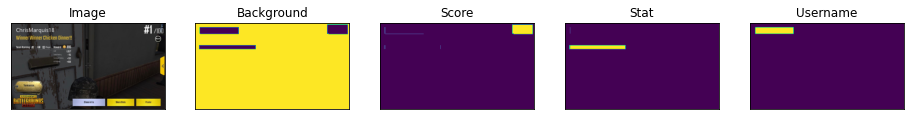

In [5]:
x_train_dir = os.path.join(WORKDIR, 'datasets', 'pubg')
y_train_dir = os.path.join(WORKDIR, 'masks','pubg')

# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['score', 'stat', 'username'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    background=mask[..., 0].squeeze(),
    score=mask[..., 1].squeeze(),
    stat=mask[..., 2].squeeze(),
    username=mask[..., 3].squeeze(),
)

### Augmentations

In [0]:
!pip install -U albumentations>=0.3.0 --user 

In [0]:
import albumentations as A

In [0]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        #A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

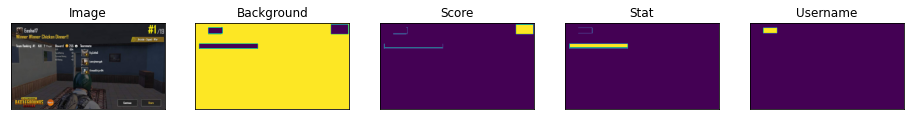

In [11]:
x_train_dir = os.path.join(WORKDIR, 'datasets', 'pubg')
y_train_dir = os.path.join(WORKDIR, 'masks','pubg')

# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['score','stat','username'])#, augmentation=get_training_augmentation())

image, mask = dataset[85] # get some sample
visualize(
    image=image, 
    background=mask[..., 0].squeeze(),
    score=mask[..., 1].squeeze(),
    stat=mask[..., 2].squeeze(),
    username=mask[..., 3].squeeze(),
)

In [0]:
import shutil
!mkdir '$WORKDIR/model'
!mkdir '$WORKDIR/model/pubg'
!mkdir '$WORKDIR/model/pubg/train'
!mkdir '$WORKDIR/model/pubg/trainannot'
!mkdir '$WORKDIR/model/pubg/val'
!mkdir '$WORKDIR/model/pubg/valannot'
!mkdir '$WORKDIR/model/pubg/test'
!mkdir '$WORKDIR/model/pubg/testannot'

#dirListing = os.listdir(os.path.join(WORKDIR, 'datasets', 'pubg'))
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(os.path.join(WORKDIR, 'datasets', 'pubg')):
    for file in f:
        if '.jpg' in file:
            #files.append(os.path.join(r, file))
            if 'pubg_100.jpg'!=file:
              files.append(file)

filesCount = len(files)

for i, file in enumerate(files):
  if (i<filesCount*0.8):
    shutil.copyfile(os.path.join(WORKDIR, 'datasets', 'pubg',file), os.path.join(WORKDIR, 'model', 'pubg','train',file))
    shutil.copyfile(os.path.join(WORKDIR, 'masks', 'pubg',file), os.path.join(WORKDIR, 'model', 'pubg','trainannot',file))
  elif (filesCount*0.8<=i<filesCount*0.9):
    shutil.copyfile(os.path.join(WORKDIR, 'datasets', 'pubg',file), os.path.join(WORKDIR, 'model', 'pubg','val',file))
    shutil.copyfile(os.path.join(WORKDIR, 'masks', 'pubg',file), os.path.join(WORKDIR, 'model', 'pubg','valannot',file))
  else:
    shutil.copyfile(os.path.join(WORKDIR, 'datasets', 'pubg',file), os.path.join(WORKDIR, 'model', 'pubg','test',file))
    shutil.copyfile(os.path.join(WORKDIR, 'masks', 'pubg',file), os.path.join(WORKDIR, 'model', 'pubg','testannot',file))

#files = []
# r=root, d=directories, f = files
#for r, d, f in os.walk(os.path.join(WORKDIR, 'masks', 'pubg')):
#    for file in f:
#        if '.jpg' in file:
#            #files.append(os.path.join(r, file))
#            files.append(file)

#filesCount = len(files)

#for i, file in enumerate(files):
#  if (i<filesCount*0.8):
#    shutil.copyfile(os.path.join(WORKDIR, 'masks', 'pubg',file), os.path.join(WORKDIR, 'model', 'pubg','trainannot',file))
#  elif (filesCount*0.8<=i<filesCount*0.9):
#    shutil.copyfile(os.path.join(WORKDIR, 'masks', 'pubg',file), os.path.join(WORKDIR, 'model', 'pubg','valannot',file))
#  else:
#    shutil.copyfile(os.path.join(WORKDIR, 'masks', 'pubg',file), os.path.join(WORKDIR, 'model', 'pubg','testannot',file))

## Segmentation model training

In [13]:
#!pip install -U --pre segmentation-models --user
!pip install segmentation-models
#!pip install imantics

In [14]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [0]:
BACKBONE = 'resnet34'
BATCH_SIZE = 5
CLASSES = ['score', 'stat', 'username']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [16]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet')













85524480/85521592 [==============================] - 2s 0us/step



In [0]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
#model.compile(optim, total_loss, metrics)
model.compile(
    optim,
    loss=sm.losses.bce_jaccard_loss,
    metrics=metrics)

model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score])

In [0]:
WORKDIR = 'segmentation'
x_train_dir = os.path.join(WORKDIR, 'model', 'pubg','train')
y_train_dir = os.path.join(WORKDIR, 'model','pubg','trainannot')

x_valid_dir = os.path.join(WORKDIR, 'model', 'pubg','val')
y_valid_dir = os.path.join(WORKDIR, 'model', 'pubg','valannot')

x_test_dir = os.path.join(WORKDIR, 'model', 'pubg','test')
y_test_dir = os.path.join(WORKDIR, 'model', 'pubg','testannot')

# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES,
    #augmentation=get_training_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    #augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

#print(train_dataloader[0][0].shape)
#print(train_dataloader[0][1].shape)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    #keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [43]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/40
14/14 [==============================] - 183s 13s/step - loss: 1.2631 - iou_score: 0.1372 - val_loss: 1.2651 - val_iou_score: 0.2353
Epoch 2/40
14/14 [==============================] - 179s 13s/step - loss: 0.8736 - iou_score: 0.2697 - val_loss: 1.2103 - val_iou_score: 0.2064
Epoch 3/40
14/14 [==============================] - 180s 13s/step - loss: 0.6125 - iou_score: 0.4367 - val_loss: 0.8981 - val_iou_score: 0.2530
Epoch 4/40
14/14 [==============================] - 181s 13s/step - loss: 0.4167 - iou_score: 0.6100 - val_loss: 0.7359 - val_iou_score: 0.3756
Epoch 5/40
14/14 [==============================] - 183s 13s/step - loss: 0.2924 - iou_score: 0.7283 - val_loss: 0.7341 - val_iou_score: 0.4024
Epoch 6/40
14/14 [==============================] - 180s 13s/step - loss: 0.2438 - iou_score: 0.7760 - val_loss: 0.8127 - val_iou_score: 0.4386
Epoch 7/40
14/14 [==============================] - 181s 13s/step - loss: 0.2111 - iou_score: 0.8079 - val_loss: 0.4218 - val_iou_score:

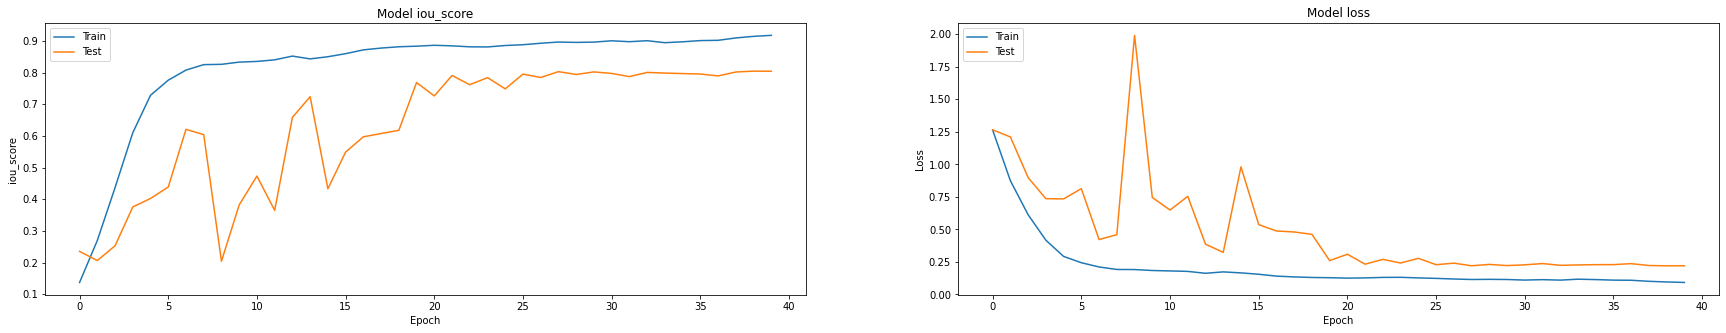

In [44]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [0]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    #augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [0]:
# load best weights
model.load_weights('best_model.h5') 

In [49]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.2886
mean iou_score: 0.734


# Visualization of results on test dataset

[1 4 2 3 7]


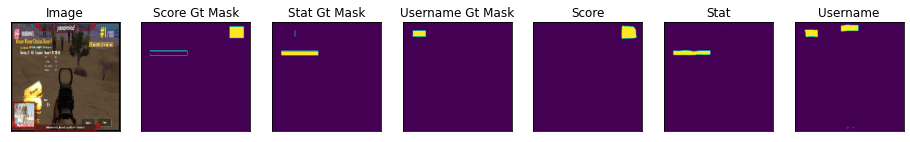

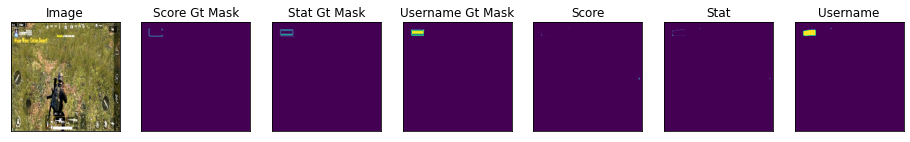

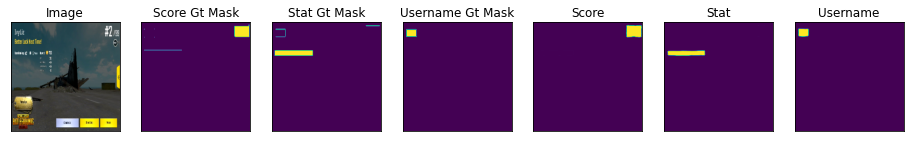

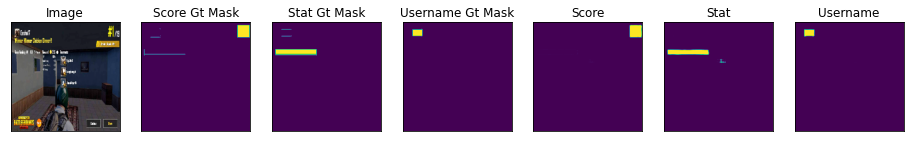

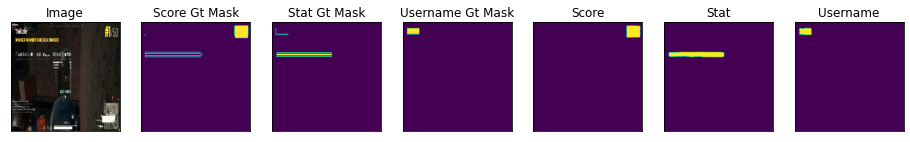

In [60]:
import keras_preprocessing.image.utils as image_utils
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

print(ids)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    gt_mask = image_utils.img_to_array(gt_mask)
    
    visualize(
        image=denormalize(image.squeeze()),
        score_gt_mask=gt_mask[..., 1].squeeze(),
        stat_gt_mask=gt_mask[..., 2].squeeze(),
        username_gt_mask=gt_mask[..., 3].squeeze(),
        #pr_mask=pr_mask.squeeze(),
        score=pr_mask[..., 1].squeeze(),
        stat=pr_mask[..., 2].squeeze(),
        username=pr_mask[..., 3].squeeze(),
    )